In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


import hydra
from typing import Optional
from collections.abc import Callable
from omegaconf import OmegaConf, DictConfig
# /usr/src/bevtransformer/bev_transformer/data/data_module.py
from data_module.lightning_data_module import DataModule
from bev_transformer.data.data_module import DataModule as ori_D
from hydra import initialize, initialize_config_module, initialize_config_dir, compose

In [2]:
def setup(cfg):

    cfg.loader.batch_size = 1

    if 'split' not in cfg:
        cfg.split = 'val'

    if 'shuffle' not in cfg:
        cfg.shuffle = False
        
def setup_config(cfg: DictConfig, override: Optional[Callable] = None):

    OmegaConf.set_struct(cfg, False)
    OmegaConf.resolve(cfg)
    OmegaConf.set_struct(cfg, True)


def merge_rgbs(imgs):

    fl = np.transpose(imgs[0], (1,2,0))
    ff = np.transpose(imgs[1], (1,2,0))
    fr = np.transpose(imgs[2], (1,2,0))

    front = np.hstack([fl, ff, fr])

    bl = np.transpose(imgs[5], (1,2,0))
    bf = np.transpose(imgs[4], (1,2,0))
    br = np.transpose(imgs[3], (1,2,0))

    back = np.hstack([bl, bf, br])

    whole = np.vstack([front, back])

    return whole

def vis_gt(bev):
    bev = np.transpose(bev, (1, 2, 0))
    area = bev[:,:,0] + bev[:,:,1]
    divider = bev[:,:,2] + bev[:,:,3]
    vehicle = bev[:,:,4] + bev[:,:,5] + bev[:,:,6] + bev[:,:,7]

    h, w = area.shape
    vis = np.full((h, w, 3), 255, dtype='uint8')

    
    for i, bibev in enumerate([area, divider, vehicle]):
    # for i, bibev in enumerate([area, vehicle]):
        vis[bibev!=0,:] = mapping[i]
    
    vis[95:105, 98:102, :] = (255, 0, 0)

    return vis

In [3]:
# *  config setup  * #
CONFIG_PATH = '/usr/src/CV_For_Autonomous_Driving/config'

with initialize_config_dir(config_dir=CONFIG_PATH):
    cfg_ourD = compose(config_name='default_config_debug.yaml')
    
setup_config(cfg_ourD, setup)

# dataset list 만드는 test
DM_our = DataModule('nuscenes_generated', cfg_ourD.data, cfg_ourD.loader)

split = 'val'
data_cfg_our = DM_our.data_cfg
datasets_our = DM_our.get_data(split=split,
                            **data_cfg_our)

# datasets = DM.get_dataset_bevdepth(split=split,
#                             **data_cfg)

print(f'In {split} dataset, {len(datasets_our)} scenes are included.')


# dataset init test
# total = 0
# for dataset in datasets:
#     total += len(dataset)

# print(f'nuscenes train has {total} data samples')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  after removing the cwd from sys.path.


In val dataset, 150 scenes are included.


In [5]:
# *  config setup  * #
CONFIG_PATH = '/usr/src/CV_For_Autonomous_Driving/config'

with initialize_config_dir(config_dir=CONFIG_PATH):
    cfg_oriD = compose(config_name='default_config_debug_sameD.yaml')
    
setup_config(cfg_oriD, setup)

# dataset list 만드는 test
DM_ori = ori_D(dataset='nuscenes_generated',data_config= cfg_oriD.data, loader_config=cfg_oriD.loader)

split = 'val'
data_cfg_ori = DM_ori.data_config
datasets_ori = DM_ori.get_data(split=split,
                            **data_cfg_ori)

# datasets = DM.get_dataset_bevdepth(split=split,
#                             **data_cfg)

print(f'In {split} dataset, {len(datasets_ori)} scenes are included.')


# dataset init test
# total = 0
# for dataset in datasets:
#     total += len(dataset)

# print(f'nuscenes train has {total} data samples')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  after removing the cwd from sys.path.


In val dataset, 150 scenes are included.


In [6]:
# dataset __getitem__ test
data = datasets_our[0].__getitem__(5) #! Dataset output LIST 임
data_ori = datasets_ori[0].__getitem__(5) #! Dataset output LIST 임
# for k, v in data.items():
#     print(f'{k}: {v.shape}')

### Visualization: depth ground truth

KeyError: 'depth'

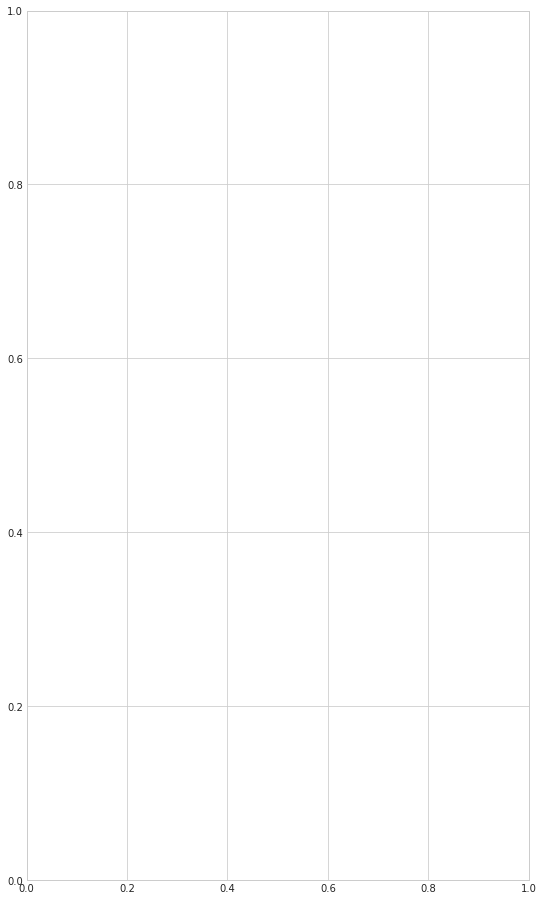

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(9, 16))

# fig.canvas.set_window_title(sample_token)
img = np.transpose(data['image'][0].numpy(), (1,2,0))
depth = data['depth'][0].numpy()
depth_ori = data_ori['depth'][0].numpy()
# debug_d = data['debug_d'][0]

h, w = depth.shape

x = np.linspace(0, w, w)
y = np.linspace(0, h, h)
xs, ys = np.meshgrid(x, y)

xs_flat = xs.flatten()
ys_flat = ys.flatten()
depth_flat = depth.flatten()

mask = depth_flat > 1e-5
xs_filter = xs_flat[mask]
ys_filter = ys_flat[mask]
depth_filter = depth_flat[mask]

print(np.unique(depth_filter))

ax.imshow(img)
ax.scatter(xs_filter, ys_filter, c=depth_filter, s=3, cmap='coolwarm') 


ax.axis('off')

[ 3.53557396  3.55076766  3.56582236 ... 82.61301422 89.02312469
 90.41094208]


(-0.5, 1599.5, 899.5, -0.5)

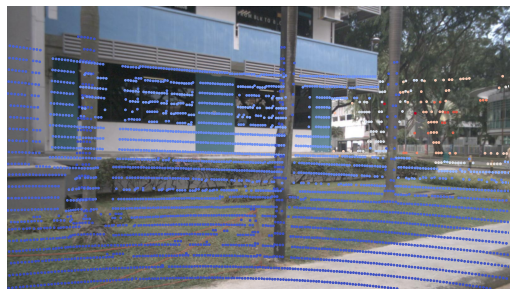

In [9]:
fig_ori, ax_ori = plt.subplots(1, 1, figsize=(9, 16))
img_ori = np.transpose(data_ori['image'][0].numpy(), (1,2,0))
h, w = depth_ori.shape

x = np.linspace(0, w, w)
y = np.linspace(0, h, h)
xs, ys = np.meshgrid(x, y)

xs_flat = xs.flatten()
ys_flat = ys.flatten()
depth_flat_ori = depth_ori.flatten()

mask = depth_flat_ori > 1e-5
xs_filter = xs_flat[mask]
ys_filter = ys_flat[mask]
depth_filter_ori = depth_flat_ori[mask]

print(np.unique(depth_filter_ori))

ax_ori.imshow(img_ori)
ax_ori.scatter(xs_filter, ys_filter, c=depth_filter_ori, s=3, cmap='coolwarm') 


ax_ori.axis('off')

In [10]:
print(np.all(depth==depth_ori))

True


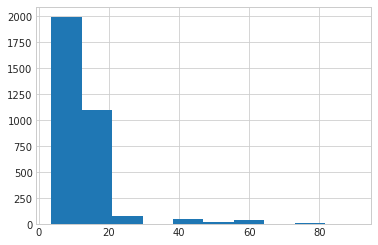

In [11]:
plt.hist(depth_filter)
plt.show()

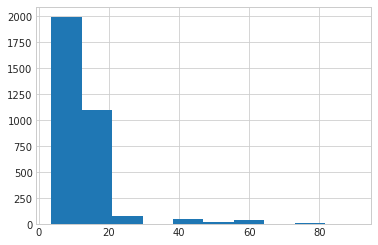

In [12]:
plt.hist(depth_filter_ori)
plt.show()

### Visualization: 3d bbox ground truth & BEV segmentation map

In [12]:
# 3d bbox 
mapping = {0: (255, 153, 51),
            1: (0, 128, 255),
            2: (0, 0, 255)}

bev_map = np.full((200, 200, 3), 255)

gt_bbox = data['gt_box']
gt_cls = data['gt_label'].numpy()

# merge images
merged_imgs = merge_rgbs(data['image'].numpy())
# bev: torch.Size([200, 200, 12])
bev = vis_gt(data['bev'].numpy())

np.unique(data['bev'].numpy())

gt_bbox_ori = data_ori['gt_box']
gt_cls_ori = data_ori['gt_label'].numpy()

# merge images
merged_imgs_ori = merge_rgbs(data_ori['image'].numpy())
# bev: torch.Size([200, 200, 12])
bev_ori = vis_gt(data_ori['bev'].numpy())

np.unique(data_ori['bev'].numpy())

len(data['gt_box']),len(data_ori['gt_box'])


KeyError: 'gt_box'

In [13]:
cls_mapping = {}
for i in range(10):
    cls_mapping[i] = np.random.rand((3))*255

In [14]:
from data_module.dataset.utils import *
#(0,0), top left
bev_cfg = {'h': 200, 'w': 200, 
                    'h_meters': 100.0, 'w_meters': 100.0, 'offset': 0.0}
meter2pix = get_bev_meter2pix_matrix(bev_cfg)

In [15]:
import matplotlib.patches as patches
bev_map = np.full((200, 200, 3), 255)
for i in range(len(gt_bbox)):
    l, w, h = gt_bbox[i][3:6] 

    # 3D bounding box corners. (Convention: x points forward, y to the left, z up.)
    x_corners = l / 2 * np.array([1,  1,  1,  1, -1, -1, -1, -1])
    y_corners = w / 2 * np.array([1, -1, -1,  1,  1, -1, -1,  1])
    z_corners = h / 2 * np.array([1,  1, -1, -1,  1,  1, -1, -1])
    corners = np.vstack((x_corners, y_corners, z_corners))

    # Rotate
    #! 필수!! 
    # print(gt_bbox[i][6])
    corners = np.dot(gt_bbox[i][6].rotation_matrix, corners)

    # Translate
    x, y, z = gt_bbox[i][:3]
    corners[0, :] = corners[0, :] + x
    corners[1, :] = corners[1, :] + y
    corners[2, :] = corners[2, :] + z
    # print('corners', corners.shape)
    p =corners[:, [2, 3, 7, 6]]


    
    gt_box = gt_bbox[i]


    h, w = 200,200
    V = meter2pix 
    S = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
    ])


    p = np.pad(p, ((0, 1), (0, 0)), constant_values=1.0)     
    p = V @ S @ p  
    if (p[0][0] < 0 or p[0][0]> 200) or (p[0][3] < 0 or p[0][3] > 200) \
        or (p[1][0] < 0 or p[1][0]  > 200) or (p[1][3]  < 0 or p[1][3] > 200):
        continue 

    bbox = p[:2, :4]
    bev_map = cv2.fillPoly(bev_map.astype(np.int32), [bbox.round().astype(np.int32).T], 1, cv2.LINE_8)

(-0.5, 199.5, 199.5, -0.5)

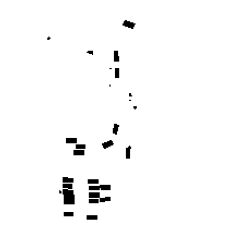

In [16]:
plt.imshow(bev_map)
plt.axis('off')

In [17]:
import matplotlib.patches as patches
bev_map_ori = np.full((200, 200, 3), 255)
for i in range(len(gt_bbox_ori)):
    l, w, h = gt_bbox_ori[i][3:6] 

    # 3D bounding box corners. (Convention: x points forward, y to the left, z up.)
    x_corners = l / 2 * np.array([1,  1,  1,  1, -1, -1, -1, -1])
    y_corners = w / 2 * np.array([1, -1, -1,  1,  1, -1, -1,  1])
    z_corners = h / 2 * np.array([1,  1, -1, -1,  1,  1, -1, -1])
    corners = np.vstack((x_corners, y_corners, z_corners))

    # Rotate
    #! 필수!! 
    # print(gt_bbox[i][6])
    corners = np.dot(gt_bbox_ori[i][6].rotation_matrix, corners)

    # Translate
    x, y, z = gt_bbox_ori[i][:3]
    corners[0, :] = corners[0, :] + x
    corners[1, :] = corners[1, :] + y
    corners[2, :] = corners[2, :] + z
    # print('corners', corners.shape)
    p =corners[:, [2, 3, 7, 6]]


    
    gt_box = gt_bbox_ori[i]


    h, w = 200,200
    V = meter2pix 
    S = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
    ])


    p = np.pad(p, ((0, 1), (0, 0)), constant_values=1.0)     
    p = V @ S @ p  
    if (p[0][0] < 0 or p[0][0]> 200) or (p[0][3] < 0 or p[0][3] > 200) \
        or (p[1][0] < 0 or p[1][0]  > 200) or (p[1][3]  < 0 or p[1][3] > 200):
        continue 

    bbox_ori = p[:2, :4]
    bev_map_ori = cv2.fillPoly(bev_map_ori.astype(np.int32), [bbox_ori.round().astype(np.int32).T], 1, cv2.LINE_8)
plt.imshow(bev_map_ori)
plt.axis('off')

NameError: name 'gt_bbox_ori' is not defined

In [18]:
np.all(bev_map == bev_map_ori)

False

(-0.5, 199.5, 199.5, -0.5)

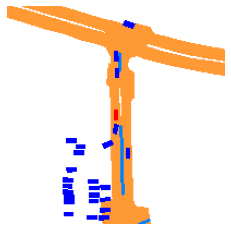

In [19]:
np.unique(data['bev'].numpy())
plt.imshow(bev)
plt.axis('off')

(-0.5, 199.5, 199.5, -0.5)

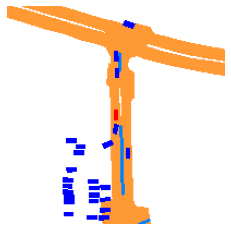

In [20]:
np.unique(data_ori['bev'].numpy())
plt.imshow(bev)
plt.axis('off')

In [7]:
import torch
torch.all(torch.nonzero(data['bev']) == torch.nonzero(data_ori['bev']))

tensor(True)

In [36]:
# torch.unique(data['bev'])
torch.nonzero(data['bev'])

tensor([[  0,   0,   0],
        [  0,   0,   1],
        [  0,   0,   2],
        ...,
        [  9, 170,  49],
        [  9, 171,  48],
        [  9, 171,  49]])

In [28]:
# torch.unique(data_ori['bev'])
data_ori['bev']

tensor([0., 1.])

In [24]:
data['bev'].shape, data_ori['bev'].shape

(torch.Size([12, 200, 200]), torch.Size([12, 200, 200]))

In [40]:
torch.nonzero(data['bev']) == torch.nonzero(data_ori['bev'])

RuntimeError: The size of tensor a (14526) must match the size of tensor b (14337) at non-singleton dimension 0

(-0.5, 4799.5, 1799.5, -0.5)

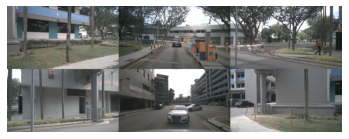

In [24]:
plt.imshow(merged_imgs)
plt.axis('off')